In [26]:
!pip install pyro-ppl==1.5.2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [27]:
df = pd.read_csv("cces_all_clean.csv")
df.head()

,abortion,state,eth,male,age,educ
0,1,MD,Other,-0.5,50-59,Some college
1,1,TN,White,-0.5,40-49,HS
2,1,OH,White,-0.5,60-69,Some college
3,0,CA,Other,-0.5,70+,Post-grad
4,1,KY,White,-0.5,40-49,HS


In [28]:
# separate between features/inputs (X) and target/output variables (y)
mat = df.values
X = mat[:,1:]
y = mat[:,0].astype("int")
ind = df.index.astype("int")
print(X)
print(X.shape)
print(y)
print(y.shape)
print(ind)
print(ind.shape)

[['MD' 'Other' -0.5 '50-59' 'Some college']
 ['TN' 'White' -0.5 '40-49' 'HS']
 ['OH' 'White' -0.5 '60-69' 'Some college']
 ...
 ['IN' 'White' -0.5 '18-29' 'Some college']
 ['CO' 'White' -0.5 '30-39' 'HS']
 ['GA' 'Other' 0.5 '30-39' 'Some college']]
(59810, 5)
[1 1 1 ... 0 0 0]
(59810,)
RangeIndex(start=0, stop=59810, step=1)
(59810,)


In [29]:
categories = ["state", "eth", "male", "age", "educ"]
for category in categories:
    df[category+"_cat"] = df[category].astype('category').cat.codes

In [30]:
df.dtypes

abortion       int64
state         object
eth           object
male         float64
age           object
educ          object
state_cat       int8
eth_cat         int8
male_cat        int8
age_cat         int8
educ_cat        int8
dtype: object

In [61]:
k = df[df["male_cat"] == 1]
print(k.shape[0])
print(k[k["abortion"] == 1].shape[0])
print(k[k["abortion"] == 1].shape[0]/k.shape[0])

25742
12355
0.4799549374562971


In [32]:
mat = df.iloc[:,6:].values
X = mat
X = torch.tensor(X).float()
y = torch.tensor(y).float()
print(X.shape)

torch.Size([59810, 5])


In [34]:
from torch import sigmoid
def model(X, obs=None):
    
    sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(8)*5.))
    gammas = pyro.sample("gammas", dist.Normal(torch.zeros(5), 5.0))
    alpha_educ = pyro.sample("alpha_educ", dist.Normal(torch.zeros(5), sigmas[0]))
    alpha_eth = pyro.sample("alpha_eth", dist.Normal(torch.zeros(4), sigmas[1]))
    alpha_age = pyro.sample("alpha_age", dist.Normal(torch.zeros(6), sigmas[2]))
    alpha_male_eth = pyro.sample("alpha_male_eth", dist.Normal(torch.zeros((2,4)), sigmas[3]))
    alpha_educ_age = pyro.sample("alpha_educ_age", dist.Normal(torch.zeros((5,6)), sigmas[4]))
    alpha_educ_eth = pyro.sample("alpha_educ_eth", dist.Normal(torch.zeros((5,4)), sigmas[5]))
    
    # need the GROUP LEVEL PREDICTORS data for states
    # Temporary solution
    ####################
    alpha_state = pyro.sample("alpha_state", dist.Normal(torch.zeros(50), sigmas[6]))
    ####################
    beta_male = pyro.sample("beta_male", dist.Normal(0.,5.))
    with pyro.plate("data", size=len(X), subsample_size=500) as ind:
        state = X[ind,0]
        eth = X[ind,1]
        male = X[ind,2]
        age = X[ind,3]
        educ = X[ind,4]
        y = pyro.sample("y",dist.Bernoulli(sigmoid(alpha_state[list(state)] + alpha_educ[list(educ)] + alpha_eth[list(eth)] + alpha_age[list(age)] + alpha_male_eth[list(male), list(eth)] + alpha_educ_age[list(educ),list(age)] + alpha_educ_eth[list(educ), list(eth)] + beta_male*male)), obs= obs[ind])
    return y

In [83]:

# Define guide function
guide = AutoDiagonalNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 12000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X,y)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 126872.7
[500] ELBO: 80461.0
[1000] ELBO: 63595.0
[1500] ELBO: 52269.5
[2000] ELBO: 48110.1
[2500] ELBO: 43195.0
[3000] ELBO: 41522.6
[3500] ELBO: 41458.9
[4000] ELBO: 39791.7
[4500] ELBO: 39413.2
[5000] ELBO: 39985.7
[5500] ELBO: 40474.3
[6000] ELBO: 40191.2
[6500] ELBO: 40461.5
[7000] ELBO: 39815.4
[7500] ELBO: 39459.8
[8000] ELBO: 39503.2
[8500] ELBO: 40491.7
[9000] ELBO: 40102.4
[9500] ELBO: 39959.3
[10000] ELBO: 40311.5
[10500] ELBO: 40069.2
[11000] ELBO: 40026.5
[11500] ELBO: 40165.1


In [92]:
def model2(X, obs=None):
    
    sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(8)*5))
    gammas = pyro.sample("gammas", dist.Normal(torch.zeros(5), 5.0))
    alpha_educ = pyro.sample("alpha_educ", dist.Normal(torch.zeros(5), sigmas[0]))
    alpha_eth = pyro.sample("alpha_eth", dist.Normal(torch.zeros(4), sigmas[1]))
    alpha_age = pyro.sample("alpha_age", dist.Normal(torch.zeros(6), sigmas[2]))
    alpha_male_eth = pyro.sample("alpha_male_eth", dist.Normal(torch.zeros((2,4)), sigmas[3]))
    alpha_educ_age = pyro.sample("alpha_educ_age", dist.Normal(torch.zeros((5,6)), sigmas[4]))
    alpha_educ_eth = pyro.sample("alpha_educ_eth", dist.Normal(torch.zeros((5,4)), sigmas[5]))
    
    # need the GROUP LEVEL PREDICTORS data for states
    # Temporary solution
    ####################
    alpha_state = pyro.sample("alpha_state", dist.Normal(torch.zeros(50), sigmas[6]))
    ####################
    beta_male = pyro.sample("beta_male", dist.Normal(0.,5.))
    with pyro.plate("data"):
        y = pyro.sample("y",dist.Bernoulli(sigmoid(alpha_state[list(X[:,0])]+alpha_educ[list(X[:,4])] + alpha_eth[list(X[:,1])] + alpha_age[list(X[:,3])] + alpha_male_eth[list(X[:,2]), list(X[:,1])] + alpha_educ_age[list(X[:,4]),list(X[:,3])] + alpha_educ_eth[list(X[:,4]), list(X[:,1])] + beta_male*X[:,2])), obs= obs)
    return y

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(model2)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X,y)

# Show summary of inference results
mcmc.summary()

Warmup:   2%|▏         | 26/1200 [1:34:07, 832.84s/it, step size=6.84e-03, acc. prob=0.758]

In [84]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha_educ", "alpha_eth", "alpha_age", "alpha_state", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth"))
samples = predictive(X, y)

In [85]:
params =["alpha_educ", "alpha_eth", "alpha_age", "alpha_state", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth"]
params_samples = {}
for param in params:
  params_samples[param] = samples[param].detach().numpy()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

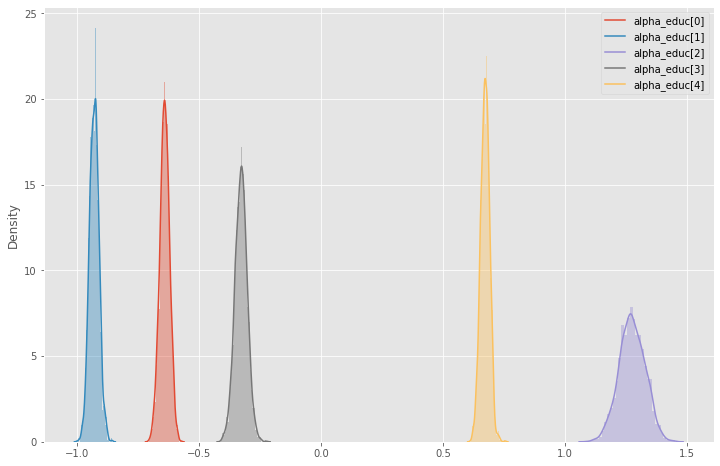

In [86]:
n_cat = 5
for c in range(n_cat):
    sns.distplot(params_samples["alpha_educ"][:,c])
plt.legend(["alpha_educ[%d]" % c for c in range(n_cat)])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

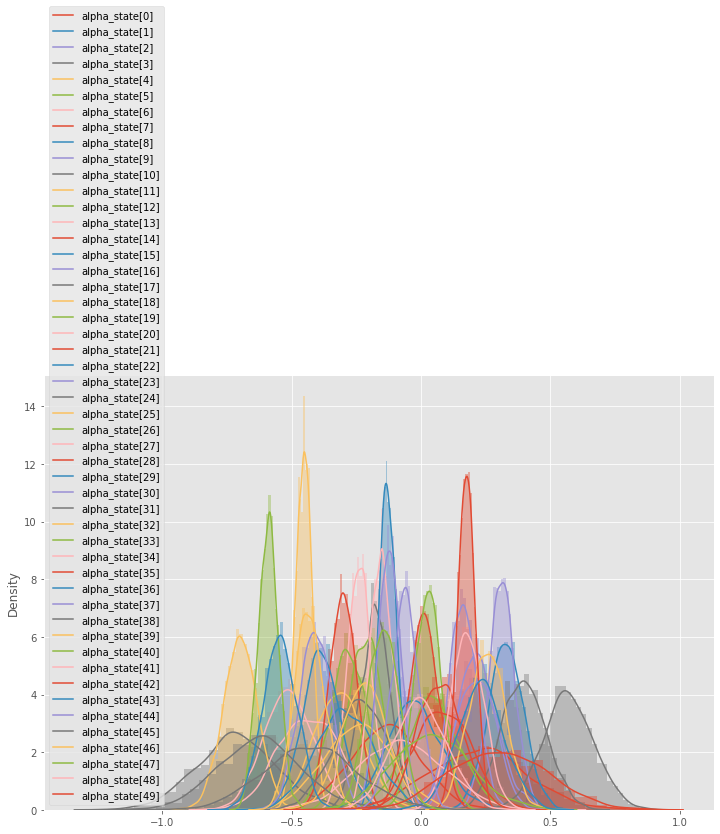

In [87]:
n_cat = 50
for c in range(n_cat):
    sns.distplot(params_samples["alpha_state"][:,c])
plt.legend(["alpha_state[%d]" % c for c in range(n_cat)])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


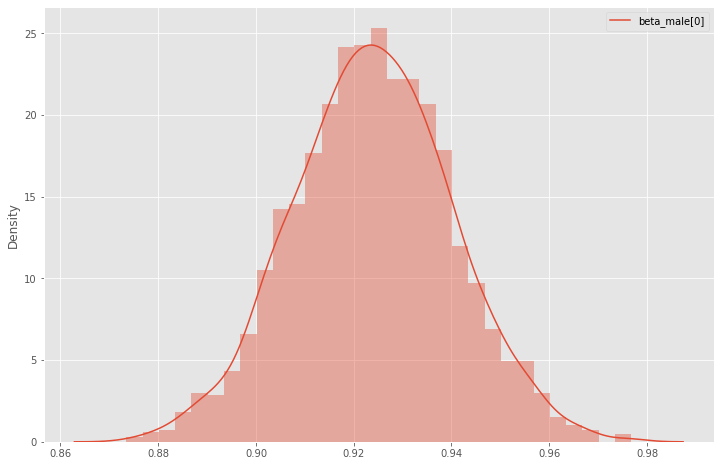

In [88]:
n_cat = 1
for c in range(n_cat):
    sns.distplot(params_samples["beta_male"][:,c])
plt.legend(["beta_male[%d]" % c for c in range(n_cat)])
plt.show()

In [89]:
# extract expected values of the parameters
params_hat = {}
for param in params:
  params_hat[param] = samples[param].mean(axis=0).detach().numpy()
#params_hat

In [90]:
# make predictions for the train set
def sigmoid_n(x):
  return 1 / (1 + np.exp(-x))
mat = df.iloc[:,6:].values
X_numpy = mat
y_hat = np.round(sigmoid_n(params_hat["alpha_state"][list(X_numpy[:,0])]+params_hat["alpha_educ"][list(X_numpy[:,4])] + params_hat["alpha_eth"][list(X_numpy[:,1])] + params_hat["alpha_age"][list(X_numpy[:,3])] + params_hat["alpha_male_eth"][list(X_numpy[:,2]), list(X_numpy[:,1])] + params_hat["alpha_educ_age"][list(X_numpy[:,4]),list(X_numpy[:,3])] + params_hat["alpha_educ_eth"][list(X_numpy[:,4]), list(X_numpy[:,1])] +params_hat["beta_male"]*X_numpy[:,2]))
y_true = y.numpy()
print("predictions:", y_hat)
print("true values:", y_true)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_true) / len(y_true))

predictions: [0. 1. 0. ... 0. 0. 1.]
true values: [1. 1. 1. ... 0. 0. 0.]
Accuracy: 0.6032770439725799
